In [2]:
import pandas as pd
from finta import TA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
'''
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
'''

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("./bitcoin_2010-07-24_2023-08-23.csv")
df['Start']=pd.to_datetime(df['Start'])
df.set_index('Start',inplace=True)
df.sort_index(ascending=True,inplace=True)
df.drop('End',axis=1,inplace=True)
df

,Open,High,Low,Close,Volume,Market Cap
Start,,,,,,
2010-07-24,0.0545,0.0545,0.0545,0.0545,0.000000e+00,0.000000e+00
2010-07-25,0.0505,0.0505,0.0505,0.0505,0.000000e+00,0.000000e+00
2010-07-26,0.0560,0.0560,0.0560,0.0560,0.000000e+00,0.000000e+00
2010-07-27,0.0600,0.0600,0.0600,0.0600,0.000000e+00,0.000000e+00
2010-07-28,0.0589,0.0589,0.0589,0.0589,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
2023-08-18,26659.8500,26784.2300,25721.5300,26058.2600,7.032831e+10,5.115170e+11
2023-08-19,26069.2300,26253.2600,25814.2500,26090.6300,4.769626e+10,5.060530e+11
2023-08-20,26085.1800,26267.3300,26002.0300,26180.0000,3.624048e+10,5.084380e+11


In [4]:
# Get technical indicator
def get_ta(df):
    df['ADX'] = TA.ADX(df)

    # Calculate RSI
    df['RSI'] = TA.RSI(df)

    # Calculate Bollinger Bands
    bollinger_bands = TA.BBANDS(df)
    df['BollingerUpper'] = bollinger_bands['BB_UPPER']
    df['BollingerMiddle'] = bollinger_bands['BB_MIDDLE']
    df['BollingerLower'] = bollinger_bands['BB_LOWER']

    df.dropna(inplace=True)
    return df

In [5]:
def label_market(df, criteria):
    df['MarketLabel'] = 0
    indices = df.index.tolist()
    
    for i in range(len(indices)):
        current_index = indices[i]
        trendy_count = 0
        
        if df.loc[current_index, 'ADX'] > 25:
            trendy_count += 1
        
        if df.loc[current_index, 'RSI'] < 30 or df.loc[current_index, 'RSI'] > 70:
            trendy_count += 1

        if i > 0:
            previous_index = indices[i-1]
            current_width = df.loc[current_index, 'BollingerUpper'] - df.loc[current_index, 'BollingerLower']
            previous_width = df.loc[previous_index, 'BollingerUpper'] - df.loc[previous_index, 'BollingerLower']
            
            if current_width > previous_width:
                trendy_count += 1

        if trendy_count >= criteria:
            df.loc[current_index, 'MarketLabel'] = 1  # Trendy
            
    return df

In [6]:
def plot_colored_market_trends(df):
    fig, ax = plt.subplots()
    prev_price = df['Close'].iloc[0]
    prev_date = df.index[0]
    prev_label = df['MarketLabel'].iloc[0]

    for date, row in df.iterrows():
        current_price = row['Close']
        current_label = row['MarketLabel']
        
        color = 'g' if current_label == 1 else 'b'
        
        ax.plot([prev_date, date], [prev_price, current_price], color=color)
        
        prev_price = current_price
        prev_date = date
        prev_label = current_label

    ax.set_title('BTC Prices with Market Labels')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

    plt.show()

In [8]:
df = get_ta(df)
df = label_market(df,2)

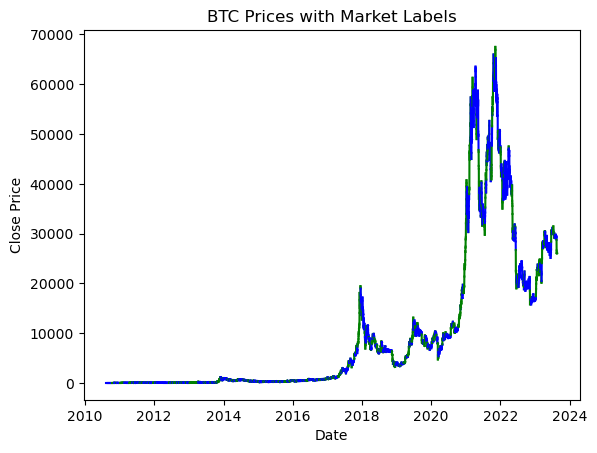

In [8]:
plot_colored_market_trends(df)

In [9]:
df['MarketLabel'].value_counts()

0    2922
1    1837
Name: MarketLabel, dtype: int64

In [11]:
X = df.drop(columns=["MarketLabel"])
y = df["MarketLabel"]

In [11]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [18]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Fit the scaler to the features training dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## SVM Model 

In [19]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()

# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
print(svm_pred)

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0
 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [20]:
accuracy_score(y_test, svm_pred)

0.7404021937842779

In [21]:
# Generate a confusion matrix for the model

confusion_matrix(y_test, svm_pred)

array([[310,  73],
       [ 69,  95]])

In [23]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       383
           1       0.57      0.58      0.57       164

    accuracy                           0.74       547
   macro avg       0.69      0.69      0.69       547
weighted avg       0.74      0.74      0.74       547



In [17]:
# gradient bosting - Haywar 
# neural network - Nariman 
# logistic regressionaccuracy_score(y_test, predictions) - Ramees 
# random forest - Ramees 
# LSM models  - Vishnu 


# GB Model 

In [24]:
# Initialize Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model
gb_clf.fit(X_train_scaled, y_train)

# Predict the labels
y_pred = gb_clf.predict(X_test_scaled)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       383
           1       0.72      0.78      0.75       164

    accuracy                           0.84       547
   macro avg       0.81      0.82      0.82       547
weighted avg       0.85      0.84      0.84       547



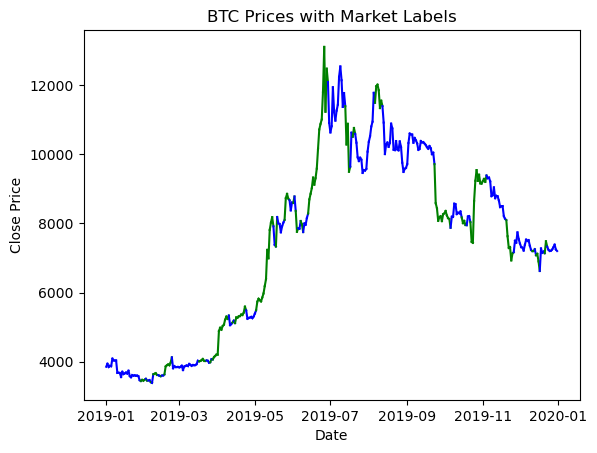

In [19]:
filtered_df = df['2019-01-01':'2019-12-31']
plot_colored_market_trends(filtered_df)

## Logistics Regression

In [25]:
lg_model = LogisticRegression(random_state=1)  

# Fit the model using training data
lg_model.fit(X_train_scaled,y_train)

LogisticRegression(random_state=1)

In [26]:
lg_predictions = lg_model.predict(X_test_scaled)

In [27]:
accuracy_score(y_test, lg_predictions)

0.7330895795246801

In [28]:
confusion_matrix(y_test, lg_predictions)

array([[365,  18],
       [128,  36]])

In [29]:
print(classification_report(y_test, lg_predictions))

              precision    recall  f1-score   support

           0       0.74      0.95      0.83       383
           1       0.67      0.22      0.33       164

    accuracy                           0.73       547
   macro avg       0.70      0.59      0.58       547
weighted avg       0.72      0.73      0.68       547



## Random Forest 

In [32]:
rf_model = RandomForestClassifier(random_state=1)

# Fit the model using training data
rf_model.fit(X_train_scaled,y_train)

RandomForestClassifier(random_state=1)

In [33]:
rf_predictions = rf_model.predict(X_test_scaled)

In [34]:
accuracy_score(y_test, rf_predictions)

0.7787934186471663

In [35]:
confusion_matrix(y_test, rf_predictions)

array([[287,  96],
       [ 25, 139]])

In [36]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.92      0.75      0.83       383
           1       0.59      0.85      0.70       164

    accuracy                           0.78       547
   macro avg       0.76      0.80      0.76       547
weighted avg       0.82      0.78      0.79       547



## LSTM

In [30]:
nn = Sequential()

# Creating the first hidden layer
nn.add(LSTM(units = 70, return_sequences = True, input_shape = (X_train_scaled.shape[1],1)))
nn.add(Dropout(0.2))

# Creating the second hidden layer
nn.add(LSTM(units = 60, return_sequences = True, activation = 'relu'))
nn.add(Dropout(0.1))

# Creating the third hidden layer
nn.add(LSTM(units = 60, return_sequences = True, activation = 'relu'))
nn.add(Dropout(0.1))

# Creating the fourth hidden layer
nn.add(LSTM(units = 60, activation = 'relu'))
nn.add(Dropout(0.1))

# Creating the output layer to the model 
nn.add(Dense(units = 1, activation= 'sigmoid'))


In [31]:
# Display the LSTM model summary
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11, 70)            20160     
                                                                 
 dropout (Dropout)           (None, 11, 70)            0         
                                                                 
 lstm_1 (LSTM)               (None, 11, 60)            31440     
                                                                 
 dropout_1 (Dropout)         (None, 11, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 11, 60)            29040     
                                                                 
 dropout_2 (Dropout)         (None, 11, 60)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60)                2

In [32]:
# Compile the model
nn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])


In [33]:
# Fit the model with the scaled train data and corresponding lables with 50 epochs
nn.fit(X_train_scaled, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
112/112 [==============================] - 22s 55ms/step - loss: 0.2378 - accuracy: 0.6094
Epoch 2/50
112/112 [==============================] - 6s 55ms/step - loss: 0.2246 - accuracy: 0.6243
Epoch 3/50
112/112 [==============================] - 6s 54ms/step - loss: 0.2076 - accuracy: 0.6918
Epoch 4/50
112/112 [==============================] - 6s 55ms/step - loss: 0.2016 - accuracy: 0.6985
Epoch 5/50
112/112 [==============================] - 6s 55ms/step - loss: 0.1979 - accuracy: 0.7083
Epoch 6/50
112/112 [==============================] - 6s 55ms/step - loss: 0.1941 - accuracy: 0.7142
Epoch 7/50
112/112 [==============================] - 6s 55ms/step - loss: 0.1908 - accuracy: 0.7249
Epoch 8/50
112/112 [==============================] - 6s 54ms/step - loss: 0.1839 - accuracy: 0.7386
Epoch 9/50
112/112 [==============================] - 6s 54ms/step - loss: 0.1797 - accuracy: 0.7450
Epoch 10/50
112/112 [==============================] - 6s 55ms/step - loss: 0.1777 - accur

In [34]:
# Display the prdictions by the model on the test data
pred = nn.predict(X_test_scaled)

# convert predictions to binary and required data structure
lstm_pred= np.where(pred > 0.5, 1, 0).ravel()
lstm_pred

38/38 [==============================] - 3s 19ms/step


array([0, 0, 0, ..., 0, 0, 1])

In [35]:
# Obtain the classification report of the predictions
print(classification_report(y_test, lstm_pred))


              precision    recall  f1-score   support

           0       0.82      0.94      0.88       742
           1       0.87      0.65      0.74       448

    accuracy                           0.83      1190
   macro avg       0.84      0.80      0.81      1190
weighted avg       0.84      0.83      0.83      1190



In [7]:
#add backtesting with strategy 
df = pd.read_csv("./bitcoin_2010-07-24_2023-08-23.csv")
df['Start']=pd.to_datetime(df['Start'])
df.set_index('Start',inplace=True)
df.sort_index(ascending=True,inplace=True)
df.drop('End',axis=1,inplace=True)

df = get_ta(df)
df = label_market(df,2)

X = df.drop(columns=["MarketLabel"])
y = df["MarketLabel"]

split_date = pd.Timestamp('2022-01-01')
validation_date = pd.Timestamp('2023-07-01')
# Training data up to end of 2021
X_train = X.loc[:split_date]
y_train = y.loc[:split_date]

# Test data starting from 2022 to 2023-July
X_test = X.loc[split_date:validation_date]
y_test = y.loc[split_date:validation_date]

X_validation = X.loc[validation_date:]
y_validation = y.loc[validation_date:]

In [8]:
def plot_colored_market_trends_1(df,predictions):
    fig, ax = plt.subplots()
    prev_price = df['Close'].iloc[0]
    prev_date = df.index[0]
    prev_label = df['MarketLabel'].iloc[0]

    for i, (date, row) in enumerate(df.iterrows()):
        current_price = row['Close']
        current_label = predictions[i]
        
        color = 'g' if current_label == 1 else 'b'
        
        ax.plot([prev_date, date], [prev_price, current_price], color=color)
        
        prev_price = current_price
        prev_date = date
        prev_label = current_label

    ax.set_title('BTC Prices with Market Labels')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

    plt.show()

In [11]:
#validation for svm
# 1. Scale the validation data

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_validation_scaled = X_scaler.transform(X_validation)

# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
svm_model = svm_model.fit(X_train_scaled, y_train)

# 2. Make predictions on the validation data
svm_validation_pred = svm_model.predict(X_validation_scaled)

# 3. Evaluate the model's performance
print("Accuracy on validation data: ", accuracy_score(y_validation, svm_validation_pred))
print("Confusion Matrix on validation data: \n", confusion_matrix(y_validation, svm_validation_pred))
print("Classification Report on validation data: \n", classification_report(y_validation, svm_validation_pred))


Accuracy on validation data:  0.660377358490566
Confusion Matrix on validation data: 
 [[28  2]
 [16  7]]
Classification Report on validation data: 
               precision    recall  f1-score   support

           0       0.64      0.93      0.76        30
           1       0.78      0.30      0.44        23

    accuracy                           0.66        53
   macro avg       0.71      0.62      0.60        53
weighted avg       0.70      0.66      0.62        53



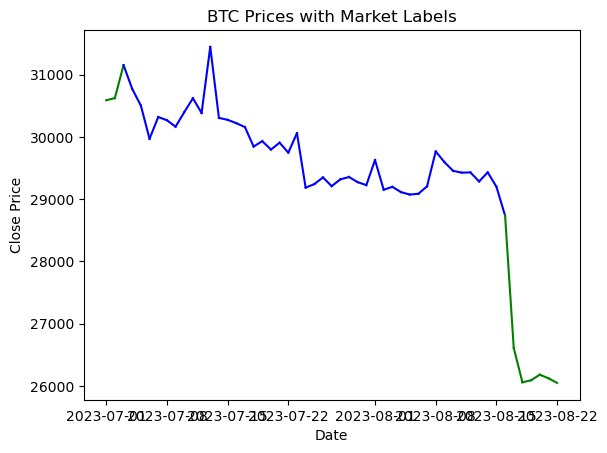

In [12]:
#validation plot for svm
plot_colored_market_trends_1(df['2023-07-01':],svm_validation_pred)